In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, MLtraining
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict

# Diffusion

In [3]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [4]:
feature_column_names=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns

Dividing the dataset into high and low risk using the PRS scores, thresholded at 0.05.

In [5]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

In [7]:
#Data exploration
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features()),
('scaler',StandardScaler()),
('pca',PCA(n_components=1))])

y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])).reshape(-1)

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)

covariates_statsmodel=sm.add_constant(covariates_statsmodel)
model=sm.OLS(y_statsmodel,covariates_statsmodel).fit()
print(model.summary(xname=['const','Gender','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     26.68
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           3.88e-23
Time:                        13:55:20   Log-Likelihood:                -554.19
No. Observations:                 151   AIC:                             1124.
Df Residuals:                     143   BIC:                             1149.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2696      1.131      2.006      0.0

In [69]:
pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features())])
y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L']))
pipe_stasmodel.named_steps['remove_zero_features'].get_column_names(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns)
y_statsmodel=pd.DataFrame(y_statsmodel)
y_statsmodel.columns=pipe_stasmodel.named_steps['remove_zero_features'].reduced_features_names

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)
model_summary=defaultdict(list)
covariates_statsmodel=sm.add_constant(covariates_statsmodel)
for connection in y_statsmodel.columns:
    model=sm.OLS(y_statsmodel.loc[:,connection],covariates_statsmodel).fit()
    result=[None]*(len(model.params)+len(model.pvalues))
    result[::2]=model.params
    result[1::2]=model.pvalues
    model_summary[connection].extend(result)

model_summary=pd.DataFrame(model_summary).T
list1=['const','Gender','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']
list2=['_coef','_pval']
model_summary.columns=[i+n for i in list1 for n in list2]

In [86]:
model_summary.sort_values(by='PRS_0.05_pval')

,const_coef,const_pval,Gender_coef,Gender_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,Anc_PC1_coef,Anc_PC1_pval,Anc_PC2_coef,Anc_PC2_pval,Anc_PC3_coef,Anc_PC3_pval,PRS_0.05_coef,PRS_0.05_pval
IFGtriang.R_ORBmid.R,0.495145,7.410349e-57,0.049203,0.065700,0.008701,0.604636,0.008174,0.625025,0.006399,0.652591,0.006035,0.650305,0.004184,0.756805,-5.143720e-02,0.000358
DCG.R_INS.R,0.178248,1.502085e-48,0.007475,0.508378,-0.003262,0.647812,0.014591,0.041469,-0.024299,0.000090,-0.011555,0.042524,0.011004,0.056855,-1.812382e-02,0.002887
SMG.L_PCG.L,0.031452,1.008841e-15,0.003198,0.517035,0.003393,0.277323,-0.003370,0.278338,-0.004474,0.091375,0.000615,0.803234,0.002906,0.247481,-7.872742e-03,0.003033
CAU.L_IFGtriang.R,0.008387,1.593129e-24,-0.000975,0.308573,-0.000202,0.738212,0.001208,0.045995,-0.000567,0.268315,-0.000264,0.581551,0.000621,0.202722,-1.513577e-03,0.003275
CAU.L_MFG.R,0.027335,1.446400e-29,-0.001679,0.533464,-0.001654,0.332142,0.005235,0.002374,-0.000748,0.603862,-0.000698,0.605006,0.000645,0.638069,-4.238381e-03,0.003472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SFGmed.L_IFGtriang.R,0.051001,2.012147e-29,0.003210,0.524980,0.001085,0.733677,-0.005465,0.086773,0.002232,0.408695,-0.000093,0.970557,0.002444,0.341484,1.160128e-05,0.996541
TPOmid.R_ROL.R,0.029199,4.712730e-54,-0.005139,0.002262,0.000543,0.604078,-0.001661,0.112239,-0.000127,0.885962,0.000198,0.810859,0.001026,0.223898,3.648522e-06,0.996684
INS.L_PreCG.L,0.813126,5.600237e-96,-0.020262,0.351525,-0.001583,0.908185,0.041802,0.002600,0.016011,0.169330,0.027717,0.011725,-0.004679,0.671762,4.296756e-05,0.997023
HES.R_ORBinf.R,0.004100,3.261112e-35,-0.000404,0.249571,0.000157,0.478304,-0.000824,0.000254,0.000124,0.506699,0.000061,0.729680,0.000015,0.934374,-3.967471e-07,0.998292


Train model on the bottom 40% (low risk) and perform PRS correlation on the top 20% (high risk)

In [6]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)
high_risk=high_risk[1:]
X_total=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])


y_total=np.asarray(european_diffusion_dataset_term['PMA_diff'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_diff'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_diff'])

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import time

In [8]:
covariates=np.asarray(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']])
covariates_low_risk=np.concatenate((StandardScaler().fit_transform(covariates[low_risk,:2]),LabelBinarizer().fit_transform(covariates[low_risk,-1])),axis=1)

PRS_score_scaler=StandardScaler().fit(adjusted_prs_score[low_risk].reshape(-1,1))
adjusted_prs_score_scaled_low_risk=PRS_score_scaler.transform(adjusted_prs_score[low_risk].reshape(-1,1)).reshape(-1)

adjusted_prs_score_scaled_high_risk=PRS_score_scaler.transform(adjusted_prs_score[high_risk].reshape(-1,1)).reshape(-1)

In [60]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True)),
('select_p_Val',MLtraining.Select_Features_Univariate(adjusted_prs_score_scaled_low_risk,covariates_low_risk))])

X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

1.5736608505249023


## Ridge

In [71]:
from sklearn.linear_model import Lasso

In [61]:
#### with RFECV

In [76]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
inner_fold_feature_selection_logs=defaultdict(list)
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    param_dict=[{'regr__alpha':np.linspace(0.1,100,100)}]
    regr=Ridge()
    pipe1=MLtraining.myPipe([('scaler', StandardScaler()),('regr',regr)])
    grid_search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval)
    pipe1=grid_search.best_estimator_
    rfecv=RFECV(pipe1).fit(X_trainval,y_trainval)
    # sfs=SequentialFeatureSelector(pipe1,cv=inner_cv,direction='backward').fit(X_trainval,y_trainval)
    # pipe1.fit(sfs.transform(X_trainval),y_trainval)
    #normal
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    # y_pred=pipe1.predict(X_test)#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    # with RFECV
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,rfecv.predict(X_trainval))
    y_pred=rfecv.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    #with SFS
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(sfs.transform(X_trainval)))
    # y_pred=pipe1.predict(sfs.transform(X_test))#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    #with RFECV
    inner_fold_feature_selection_logs[i].extend(rfecv.get_support())
    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred
    #with SFS
    # inner_fold_feature_selection_logs[i].extend(sfs.get_support())
    # #use the trained model to predict the brain age (PMA at scan) for high risk subject
    # y_high_risk_pred=pipe1.predict(sfs.transform(X_high_risk_after_pipe0))
    # y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    # y_high_risk_pred_dict[i]=y_high_risk_pred

100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


In [92]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,RMSE,Correlation,p_value
0,0.440944,0.906143,1.128722,0.754683,0.000077
1,0.515118,1.020109,1.213856,0.756575,0.000113
2,0.516621,0.780422,1.070930,0.724241,0.000305
Average,0.490895,0.902225,1.137836,0.745167,0.000165


In [91]:
MLtraining.print_scores(y_high_risk_pred_dict[1],y_high_risk)

{'r2': 0.6764730194332353,
 'MAE': 0.9384306260647389,
 'RMSE': 1.0937154567290883,
 'Correlation': 0.852273954276937,
 'p_value': 2.2849364549424557e-09}

In [46]:
result_r2=np.asarray(result_r2).reshape(-1,2)

In [49]:
r2_score(result_r2[:,0],result_r2[:,1])

0.25747809438654534

Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

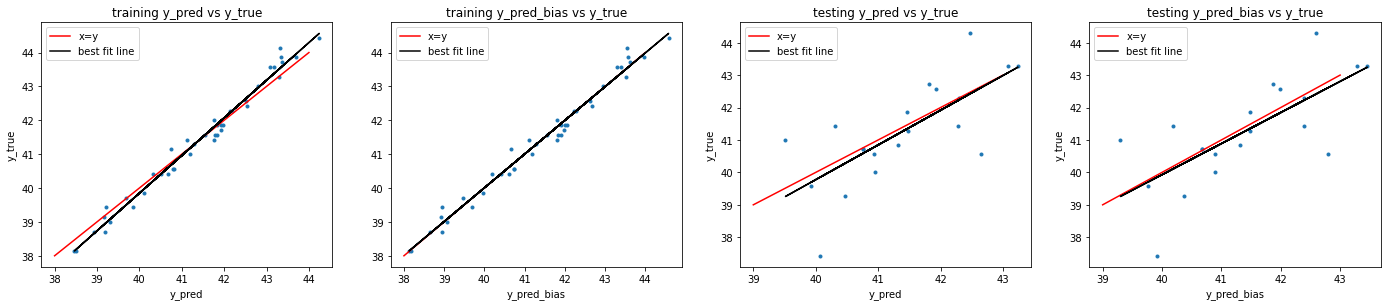

In [96]:
y_train_pred=rfecv.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=rfecv.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [95]:
MLtraining.print_scores(brain_age_difference['mean_PMA_pred'],brain_age_difference['true_PMA'])

{'r2': 0.6990112252145564,
 'MAE': 0.8753359456197711,
 'RMSE': 1.0549314673926056,
 'Correlation': 0.875257849882425,
 'p_value': 2.4835138606417555e-10}

In [93]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA,residual
0,42.799463,43.230291,42.297567,42.775773,44.714286,-1.938512
1,42.414008,42.597507,42.505171,42.505562,43.571429,-1.065867
2,40.011881,40.491193,39.974890,40.159321,41.000000,-0.840679
3,40.381565,40.463856,40.420096,40.421839,42.714286,-2.292447
4,40.235064,41.078403,41.547725,40.953731,42.285714,-1.331984
5,41.490902,42.833419,41.884465,42.069595,44.000000,-1.930405
6,41.774034,41.090266,42.123048,41.662450,42.000000,-0.337550
7,42.523774,42.301120,42.761357,42.528750,42.142857,0.385893
8,43.385205,42.760349,42.388732,42.844762,44.285714,-1.440952
9,41.635874,41.532462,42.031504,41.733280,42.000000,-0.266720


In [17]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score_scaled_high_risk))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score_scaled_high_risk))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.601909,0.000433


Text(0.5, 1.0, 'Brain maturation index in High risk neonates (diffusion dataset)')

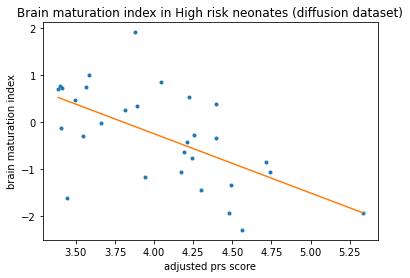

In [20]:
plt.plot(adjusted_prs_score_scaled_high_risk,brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score_scaled_high_risk.reshape(-1,1),brain_age_difference['residual'].values)
plt.plot(adjusted_prs_score_scaled_high_risk,lin_reg.predict(adjusted_prs_score_scaled_high_risk.reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.ylabel('brain maturation index')
plt.title('Brain maturation index difference in High risk neonates (diffusion dataset)')

### Checking features


In [17]:
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)
pipe0.named_steps['remove_correlation'].get_column_names(ROIs_combination_remove_zeros)
ROIs_combination_remove_correlation=pipe0.named_steps['remove_correlation'].reduced_features_names
print(ROIs_combination_remove_correlation.shape)
pipe0.named_steps['select_p_Val'].get_column_names(ROIs_combination_remove_correlation)
ROIs_combination_select_univariate=pipe0.named_steps['select_p_Val'].reduced_features_names
print(ROIs_combination_select_univariate.shape)

(2612,)
(2265,)
(175,)


In [18]:
coefs_of_prs_pval=pipe0.named_steps['select_p_Val'].coefficients[pipe0.named_steps['select_p_Val'].p_value<0.05]

In [19]:
inner_folds_selection=pd.DataFrame(inner_fold_feature_selection_logs)
inner_folds_selection=inner_folds_selection[(inner_folds_selection[0]==True)&(inner_folds_selection[1]==True)&(inner_folds_selection[2]==True)]

In [20]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_select_univariate,coefs_of_prs_pval,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Connection','PRS_coefs','PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3'])
ROIs_coef['PMA_Mean_Coef']=ROIs_coef[['PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3']].mean(axis=1)
# ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)
ROIs_coef=ROIs_coef.iloc[inner_folds_selection.index,:]

In [21]:
ROIs_coef['PRS*PMA_coefs']=ROIs_coef['PRS_coefs']*ROIs_coef['PMA_Mean_Coef']

In [22]:
ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['PRS*PMA_coefs'].abs().sort_values(ascending=False).index)

In [23]:
merged_feature_dict_strings=pipe0.named_steps['remove_correlation'].merged_feature_dict_strings
ROIs_coef_RidgeCV['Merged_Feature']=[False if not merged_feature_dict_strings[i] else True for i in ROIs_coef_RidgeCV['Connection']]

In [24]:
ROIs_coef_RidgeCV.head(10)

,Connection,PRS_coefs,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_coefs,Merged_Feature
120,PUT.L_CAU.L,-0.297101,0.079055,0.065872,0.071787,0.072238,-0.021462,False
117,PUT.L_REC.L,-0.402210,0.059788,0.041412,0.058048,0.053082,-0.021350,False
70,IPL.L_REC.L,-0.421774,-0.055757,-0.011988,-0.071998,-0.046581,0.019647,False
83,PreCUN.L_ROL.L,-0.300068,-0.080794,-0.047321,-0.065516,-0.064544,0.019367,False
12,ORBinf.R_IFGtriang.R,-0.281637,0.055965,0.064218,0.083880,0.068021,-0.019157,False
44,AMYG.R_ORBsumed.R,0.323221,0.071844,0.027964,0.075293,0.058367,0.018865,False
174,ITG.R_FFG.R,-0.286553,0.090738,0.054619,0.049347,0.064901,-0.018598,False
135,PAL.R_MOG.R,0.278513,0.047019,0.070148,0.073584,0.063584,0.017709,False
123,PUT.R_ORBinf.R,-0.353645,0.045727,0.058598,0.042885,0.049070,-0.017353,False
78,ANG.L_SPG.L,-0.401399,0.023398,0.050284,0.052834,0.042172,-0.016928,False


# Volumetric

In [35]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [36]:
feature_names_volumetric=european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]

In [37]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

In [38]:
#Data exploration
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features()),
('scaler',StandardScaler()),
('pca',PCA(n_components=1))])

y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"])).reshape(-1)

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)

covariates_statsmodel=sm.add_constant(covariates_statsmodel)
model=sm.OLS(y_statsmodel,covariates_statsmodel).fit()
print(model.summary(xname=['const','Gender','17 ICV (all except bone)','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1074.
Date:                Fri, 16 Apr 2021   Prob (F-statistic):          5.99e-123
Time:                        16:25:15   Log-Likelihood:                -220.38
No. Observations:                 151   AIC:                             458.8
Df Residuals:                     142   BIC:                             485.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [62]:
pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features())])
y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]))
pipe_stasmodel.named_steps['remove_zero_features'].get_column_names(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"].columns)
y_statsmodel=pd.DataFrame(y_statsmodel)
y_statsmodel.columns=pipe_stasmodel.named_steps['remove_zero_features'].reduced_features_names

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)
model_summary=defaultdict(list)
covariates_statsmodel=sm.add_constant(covariates_statsmodel)
for connection in y_statsmodel.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"].columns:
    model=sm.OLS(y_statsmodel.loc[:,connection],covariates_statsmodel).fit()
    result=[None]*(len(model.params)+len(model.pvalues))
    result[::2]=model.params
    result[1::2]=model.pvalues
    model_summary[connection].extend(result)

model_summary=pd.DataFrame(model_summary).T
list1=['const','Gender','17 ICV (all except bone)','GA_struc','PMA_struc','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']
list2=['_coef','_pval']
model_summary.columns=[i+n for i in list1 for n in list2]

In [63]:
model_summary.sort_values(by='PRS_0.05_pval')

,const_coef,const_pval,Gender_coef,Gender_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,GA_struc_coef,GA_struc_pval,PMA_struc_coef,PMA_struc_pval,Anc_PC1_coef,Anc_PC1_pval,Anc_PC2_coef,Anc_PC2_pval,Anc_PC3_coef,Anc_PC3_pval,PRS_0.05_coef,PRS_0.05_pval
'1 Precentral_L 2001',7487.831157,7.050624e-142,17.606846,0.855651,992.256410,3.336137e-26,-185.702244,0.001904,292.471033,0.001163,-73.208973,0.126833,-14.230417,0.746848,79.386375,0.078095,-107.522866,0.022553
'24 Frontal_Sup_Medial_R 2602',3179.003215,2.352784e-138,-23.323822,0.592306,438.381392,1.342560e-25,6.902022,0.794136,27.004085,0.497323,16.847347,0.433361,29.355774,0.140217,-19.654259,0.330336,-43.322103,0.040680
'89 Temporal_Inf_L 8301',4019.660605,4.513529e-132,26.154587,0.668360,537.314461,2.182478e-21,3.436463,0.926157,-5.587138,0.920152,10.941713,0.716421,-5.364324,0.846974,-36.661349,0.195838,-58.334561,0.049186
'76 Pallidum_R 7022',596.175431,2.921311e-151,-11.642963,0.079743,40.570539,9.534545e-13,4.489494,0.264537,-4.425244,0.463843,-2.965177,0.363899,-1.231695,0.682463,-7.659034,0.013291,-5.943106,0.064017
'34 Cingulum_Mid_R 4012',5308.942220,8.516247e-160,-87.080924,0.090584,669.241339,2.535889e-35,-77.713750,0.013446,117.256878,0.013109,5.012937,0.842712,7.018053,0.763453,1.456008,0.951023,-45.996848,0.064258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
'11 Frontal_Inf_Oper_L 2301',1607.121803,1.380819e-110,28.558984,0.412829,236.819510,8.085343e-15,-21.275991,0.315552,49.068440,0.124500,-10.013949,0.560373,-3.622417,0.819390,-4.681326,0.771651,1.942953,0.907987
'30 Insula_R 3002',4381.727683,4.121904e-154,-172.314212,0.000283,539.013519,1.046137e-30,42.821137,0.129987,-128.766903,0.002760,33.676086,0.142521,20.411719,0.334488,-19.358139,0.367871,-2.401676,0.914524
'12 Frontal_Inf_Oper_R 2302',2570.137973,9.745469e-119,74.911724,0.125077,395.664555,3.612062e-19,-33.985978,0.251166,70.732207,0.112872,14.681305,0.540977,-12.084083,0.585579,-18.076491,0.422687,2.203116,0.925224
'59 Parietal_Sup_L 6101',2359.192204,7.255567e-121,-13.265103,0.758284,305.190225,1.005537e-15,-27.653420,0.291838,98.949645,0.012893,-16.108198,0.449231,-2.015259,0.918224,15.462861,0.438900,-1.875929,0.928137


In [24]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)
high_risk=high_risk[2:]
X_total=np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,"'1 Precentral_L 2001'":"'93 Vermis'"])


y_total=np.asarray(european_diffusion_dataset_term['PMA_struc'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_struc'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_struc'])

In [25]:
covariates=np.asarray(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Gender']])

covariates_low_risk=np.concatenate((StandardScaler().fit_transform(covariates[low_risk,:3]),LabelBinarizer().fit_transform(covariates[low_risk,-1])),axis=1)

PRS_score_scaler=StandardScaler().fit(adjusted_prs_score[low_risk].reshape(-1,1))

adjusted_prs_score_scaled_low_risk=PRS_score_scaler.transform(adjusted_prs_score[low_risk].reshape(-1,1)).reshape(-1)

adjusted_prs_score_scaled_high_risk=PRS_score_scaler.transform(adjusted_prs_score[high_risk].reshape(-1,1)).reshape(-1)

In [26]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
# pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
# ('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=False)),
# ('select_p_Val',MLtraining.Select_Features_Univariate(adjusted_prs_score_scaled_low_risk,covariates_low_risk))])
# pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
# ('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True))])
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features())])
# pipe0=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=1,random_state=42))])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

0.0021550655364990234


## Ridge

In [27]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
inner_fold_feature_selection_logs=defaultdict(list)
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    param_dict=[{'regr__alpha':np.linspace(0.1,10,100)}]
    regr=Ridge()
    # regr=LinearSVR()
    # param_dict=[{'regr__C':np.linspace(0.1,10,100)}]
    # pipe1=MLtraining.myPipe([('scaler', StandardScaler()),('regr',regr)])
    pipe1=MLtraining.myPipe([('scaler',StandardScaler()),('PCA',PCA(n_components=.95)),('regr',regr)])
    grid_search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval)
    pipe1=grid_search.best_estimator_
    # rfecv=RFECV(pipe1,cv=inner_cv).fit(X_trainval,y_trainval)

    #normal
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    y_pred=pipe1.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    # with RFECV
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,rfecv.predict(X_trainval))
    # y_pred=rfecv.predict(X_test)#model performance on low risk
    # # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_

    #with normal
    y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred

    #with RFECV
    # inner_fold_feature_selection_logs[i].extend(rfecv.get_support())
    # #use the trained model to predict the brain age (PMA at scan) for high risk subject
    # y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
    # # y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    # y_high_risk_pred_dict[i]=y_high_risk_pred


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


In [28]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,RMSE,Correlation,p_value
0,0.535720,0.751404,0.998334,0.805555,0.000011
1,0.612716,0.869481,1.084835,0.814834,0.000012
2,0.683931,0.723570,0.865980,0.836189,0.000004
Average,0.610789,0.781485,0.983050,0.818859,0.000009


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

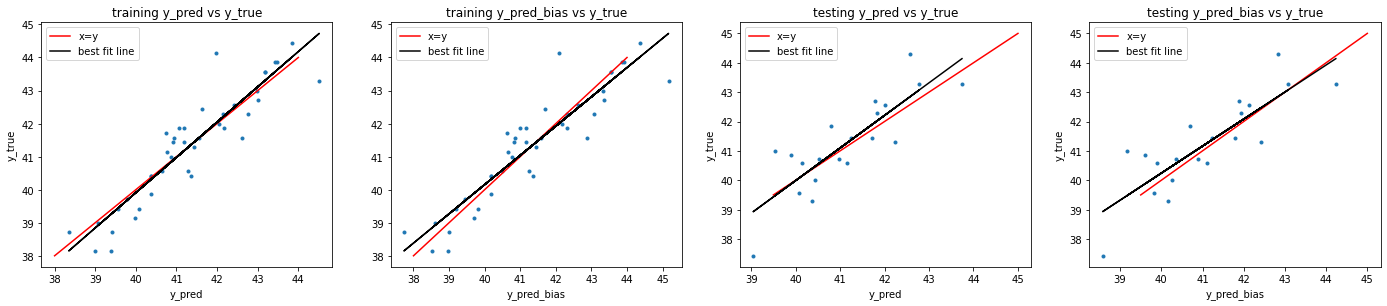

In [29]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39.5,45],[39.5,45],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39.5,45],[39.5,45],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [30]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA,residual
0,43.084185,42.049809,42.793070,42.642355,43.571429,-0.929074
1,39.570455,40.127563,40.282579,39.993533,41.000000,-1.006467
2,42.550496,42.745376,43.092937,42.796270,42.714286,0.081984
3,42.477219,42.082701,41.426144,41.995355,42.285714,-0.290360
4,43.303957,44.482553,42.397816,43.394775,44.000000,-0.605225
5,41.089522,41.500918,41.538451,41.376297,42.000000,-0.623703
6,41.007513,40.877818,40.430139,40.771823,42.142857,-1.371034
7,42.272582,44.288907,42.654657,43.072049,44.285714,-1.213666
8,41.267998,41.346833,41.242651,41.285827,42.000000,-0.714173
9,41.148358,41.656964,41.115140,41.306821,42.428571,-1.121751


In [31]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference.loc[:,'residual'],adjusted_prs_score_scaled_high_risk))[0],
'p-value':(pearsonr(brain_age_difference.loc[:,'residual'],adjusted_prs_score_scaled_high_risk))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.628929,0.000258


Text(0, 0.5, 'brain maturation index')

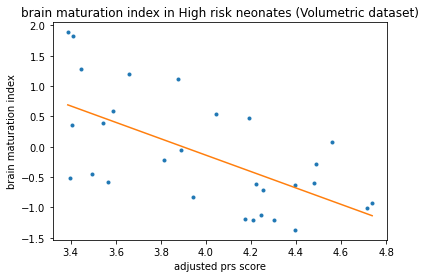

In [34]:
plt.plot(adjusted_prs_score_scaled_high_risk,brain_age_difference.loc[:,'residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score_scaled_high_risk.reshape(-1,1),brain_age_difference.loc[:,'residual'].values)
plt.plot(adjusted_prs_score_scaled_high_risk,lin_reg.predict(adjusted_prs_score_scaled_high_risk.reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.title('brain maturation index in High risk neonates (Volumetric dataset)')
plt.ylabel('brain maturation index')

### Checking features

In [304]:
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"].columns  
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)
pipe0.named_steps['remove_correlation'].get_column_names(ROIs_combination_remove_zeros)
ROIs_combination_remove_correlation=pipe0.named_steps['remove_correlation'].reduced_features_names
print(ROIs_combination_remove_correlation.shape)
pipe0.named_steps['select_p_Val'].get_column_names(ROIs_combination_remove_correlation)
ROIs_combination_select_univariate=pipe0.named_steps['select_p_Val'].reduced_features_names
print(ROIs_combination_select_univariate.shape)

(93,)
(12,)


KeyError: 'select_p_Val'

In [280]:
inner_folds_selection=pd.DataFrame(inner_fold_feature_selection_logs)
inner_folds_selection=inner_folds_selection[(inner_folds_selection[0]==True)&(inner_folds_selection[1]==True)&(inner_folds_selection[2]==True)]

In [281]:
coefs_of_prs_pval=pipe0.named_steps['select_p_Val'].coefficients[pipe0.named_steps['select_p_Val'].p_value<0.05]

In [284]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_remove_zeros,coefs_of_prs_pval,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Region','PRS_coef','PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3'])
ROIs_coef['PMA_Mean_Coef']=ROIs_coef[['PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3']].mean(axis=1)
# ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)
ROIs_coef=ROIs_coef.iloc[inner_folds_selection.index,:]
ROIs_coef['PRS*PMA_Coef']=ROIs_coef['PRS_coef']*ROIs_coef['PMA_Mean_Coef']

In [285]:
ROIs_coef_RidgeCV_VOLUME=ROIs_coef

In [287]:
merged_feature_dict_strings=pipe0.named_steps['remove_correlation'].merged_feature_dict_strings
ROIs_coef_RidgeCV_VOLUME['Merged_Feature']=[False if not merged_feature_dict_strings[i] else True for i in ROIs_coef_RidgeCV_VOLUME['Region']]

In [288]:
ROIs_coef_RidgeCV_VOLUME

,Region,PRS_coef,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_Coef,Merged_Feature
0,'1 Precentral_L 2001',-23.929817,0.829665,0.769976,0.877746,0.825796,-19.761136,False
